## Guide to using the Lightkurve package

Link to the Lightkurve documentation this was based on:
https://docs.lightkurve.org/tutorials/

Also, make sure you're using Lightkurve version 1.9.1 (current version) or this tutorial won't work.

In this notebook, we will run through examples of how to use most of Lightkurve's functions. First, we'll start with searching for the example target.

# Using and detrending Kepler lightcurve objects

In [188]:
from lightkurve import search_lightcurvefile
import numpy as np
import astropy.units as u
from matplotlib import pyplot as plt
#Using star #6 from our list of stars from Davenports paper
search_lightcurvefile('KIC 11145819')

#,observation,target_name,productFilename,distance
0,Kepler Quarter 1,kplr011145819,kplr011145819-2009166043257_llc.fits,0.0
1,Kepler Quarter 2,kplr011145819,kplr011145819-2009259160929_llc.fits,0.0
2,Kepler Quarter 3,kplr011145819,kplr011145819-2009350155506_llc.fits,0.0
3,Kepler Quarter 4,kplr011145819,kplr011145819-2010078095331_llc.fits,0.0
4,Kepler Quarter 5,kplr011145819,kplr011145819-2010174085026_llc.fits,0.0
5,Kepler Quarter 6,kplr011145819,kplr011145819-2010265121752_llc.fits,0.0
6,Kepler Quarter 7,kplr011145819,kplr011145819-2010355172524_llc.fits,0.0
7,Kepler Quarter 8,kplr011145819,kplr011145819-2011073133259_llc.fits,0.0
8,Kepler Quarter 9,kplr011145819,kplr011145819-2011177032512_llc.fits,0.0
9,Kepler Quarter 10,kplr011145819,kplr011145819-2011271113734_llc.fits,0.0


This downloads all of the available files and plots them all together using the PDCSAP Flux, which has had long term trends removed using "Cotrending Basis Vectors".

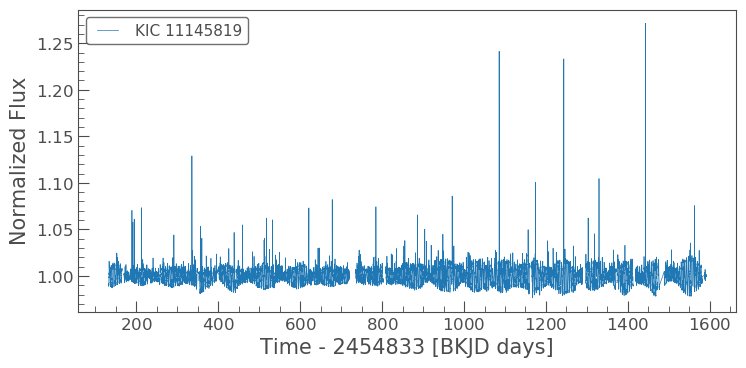

In [167]:
lcf_all = search_lightcurvefile('KIC 11145819').download_all()
lcf_all.PDCSAP_FLUX.plot()

Download one file from the list and plots- can specify which with the 'quarter' argument which corresponds to each file's Kepler Quarter in the observation column:

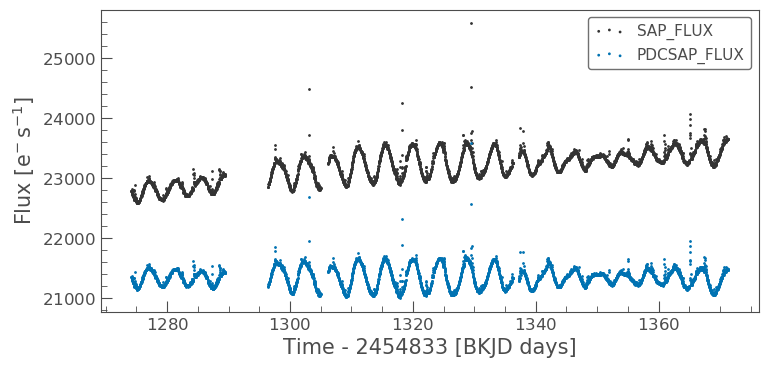

In [69]:
lcf = search_lightcurvefile('KIC 11145819',quarter=14).download()
lcf.scatter();

This shows both the SAP flux and the PDC SAP flux, but we probably want to go with the PDC SAP flux. 

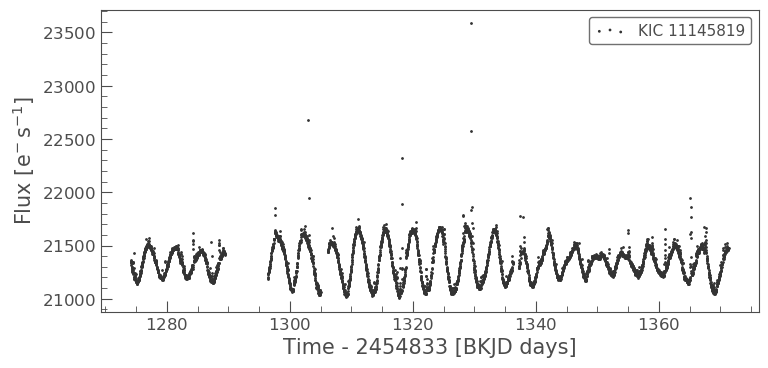

In [70]:
lcf.PDCSAP_FLUX.scatter();

Lightkurve has various built in functions that can do things such as removing outliers (using sigma clipping) and removing nans that we can use to refine the data (although I omit the outlier removing step for most of the data processing because it seems like it might remove flares as well):

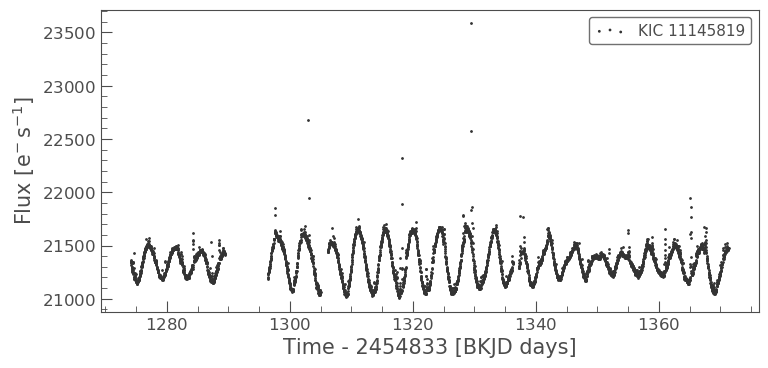

In [162]:
lc = lcf.PDCSAP_FLUX.remove_nans()
lc.scatter();

You can also check the “CDPP” noise metric of the lightcurve using the built in method:

In [72]:
lc.estimate_cdpp()

657.8531103988324

Lightkurve also has a "flatten" feature for light curves which removes long term trends using a Savitzky–Golay filter (we can define an appropriate window length for the Savitzky-Golay filter based on our noise and signal strength by adding "window length = " as an argument to flatten):

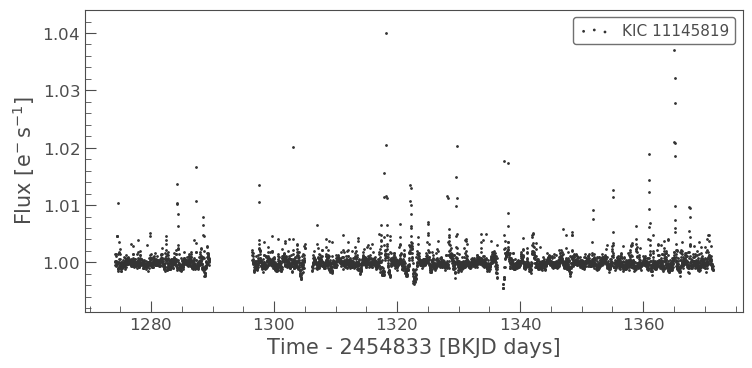

In [156]:
flat_lc = lc.flatten()
flat_lc.scatter();

Lightkurve has another function called fold that folds the data at a specified period, allowing for us to remove periodic stellar variability or variability due to a planet (But this requires us to know the period) and can adjust the bin size:

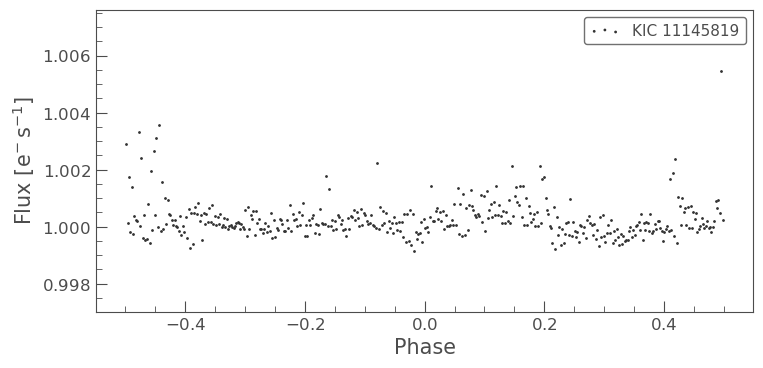

In [157]:
folded_lc = flat_lc.fold(period=4.2455794).bin(binsize=10)
folded_lc.scatter();

# Kepler lightcurve created from target pixel files

Instead of downloading the Kepler light curve files from MAST like we've been doing, lightkurve also allows for us to download the target pixel files and create a light curve from this ourselves and choose an aperture mask. We can go with the default Kepler aperture or we can create our own using a function called "interact()" that allows for a very detailed breakdown of individual pixel data in order to construct accurate pixel masks for sources that might have another bright source nearby.

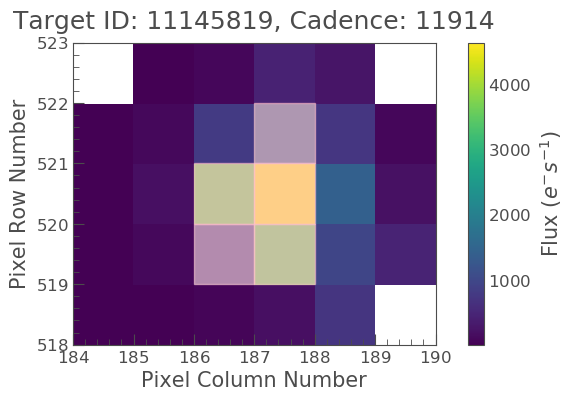

In [177]:
from lightkurve import search_targetpixelfile
tpf = search_targetpixelfile('KIC 11145819', quarter=4).download()
#Could make our own pixel mask here but I just chose the standard pipeline mask
tpf.plot(aperture_mask=tpf.pipeline_mask);

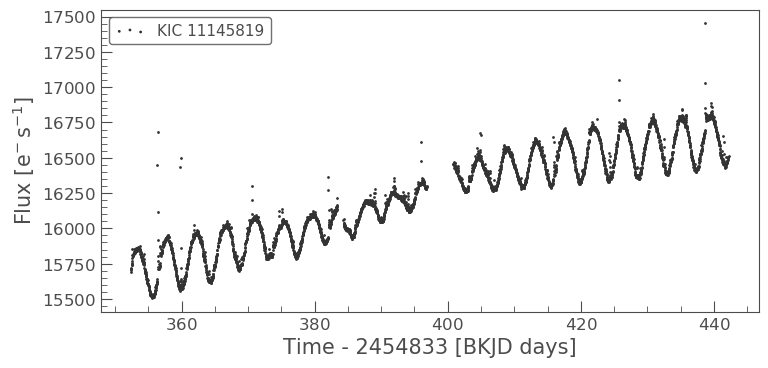

In [176]:
tpf_lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
tpf_lc.scatter()

Lightkurve also has the capability to create lightcurves from Kepler data using Point Response Function (PRF) model fitting photometry, also known as Point Spread Function (PSF) fitting photometry in which a parameterized model is fit to the data instead of using aperture photometry. It is significantly more complicated but it offers the ability to separate the signals of overlapping stars in very crowded regions or star clusters. For now I have only demonstrated the aperture photometry approach.

We can now apply the same processing functions from previous steps to this aperture photometry lightcurve, this time demonstrated all in one line since we've already seen how they work:

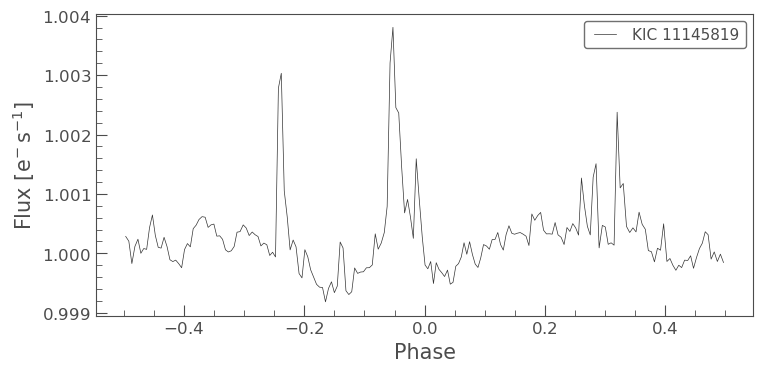

In [198]:
tpf_lc.remove_nans().flatten().fold(period=4.2455794).bin(binsize=20).plot()

# Kepler rolling band noise & background noise removal

The documentation also goes through an example to check for rolling band noise that involves looking at and plotting the background noise on its own:

C:\Users\labuser\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


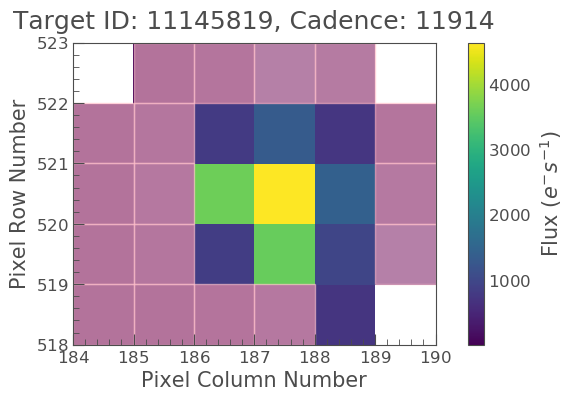

In [179]:
#Changes the aperture of the target pixel file to only include background pixels
aperture = tpf.flux[0]<200
npix = len(np.where(aperture == True)[0])
tpf.plot(aperture_mask=aperture)

According to the documentation, the mask avoids the center pixels. We can then create a light curve the same way as above, however, this time we divide by the number of pixels in the aperture to give the the average background flux per pixel. If we were to see a signal that looked like it could be due to stellar rotation or something similar, we can do this to see if it is still present in the background which would indicate it is not astrophysical.

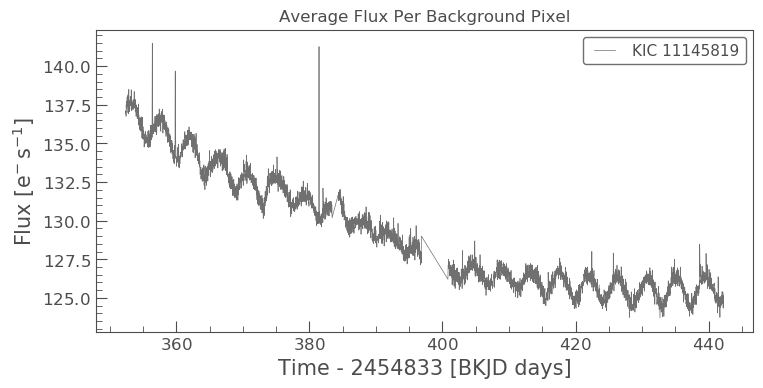

In [180]:
bkg_lc = tpf.to_lightcurve(aperture_mask=aperture)
bkg_lc /= npix  # Convert to electrons per second per pixel

ax = bkg_lc.remove_outliers().plot(normalize=False, alpha=0.7)
ax.set_title('Average Flux Per Background Pixel');

We can check this further by running the same analysis on the stars closest neighbor, which should have similar background noise levels as our target. We can check what its nearest neighbor is using lightkurve, and then rerun the background analysis.

In [182]:
#radius is in arcseconds
tpfs = search_targetpixelfile('KIC 11145819', radius=60, quarter=16, limit=2).download_all()
tpfs

TargetPixelFileCollection of 2 objects:
	11145819 (1 KeplerTargetPixelFiles) Quarters: 16
	11145891 (1 KeplerTargetPixelFiles) Quarters: 16

In [183]:
#Looks like KIC 11145891 is our current targets nearest neighbor, so we'll use this star
#This shows us their separation in pixels to verify they're close
separation = np.sqrt((tpfs[0].column - tpfs[1].column)**2 + (tpfs[0].row - tpfs[1].row)**2)
print('TPFs are {:.02} Pixels Apart'.format(separation))

TPFs are 1.3e+01 Pixels Apart


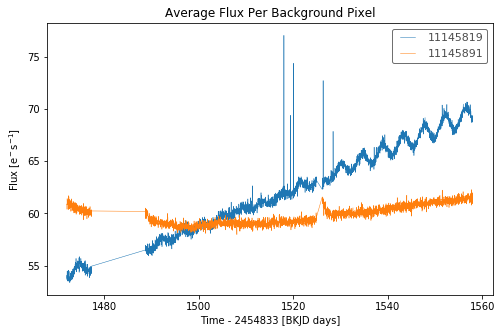

In [186]:
#This plots both of the stars and their background noise
#We can see our target has some steady periodic variability its neighbor doesn't have
#If we were to see some rolling band looking variability present in both, we could assume it was indeed a rolling band
fig, ax = plt.subplots(figsize=(8, 5))
for t in tpfs.data:
    # Construct a background aperture
    aper = np.nan_to_num(t.flux[0]) < 200
    npix = len(np.where(aper == True)[0])

    # Create a lightcurve
    bkg_lc = t.to_lightcurve(aperture_mask=aper)
    bkg_lc /= npix  # Don't forget to normalize by the number of pixels in the aperture!

    # Plot the result
    bkg_lc = bkg_lc.remove_outliers()
    bkg_lc.plot(ax=ax, normalize=False, label=t.targetid)

ax.set_title('Average Flux Per Background Pixel');

# Combining multiple Kepler lightcurves

We can also combine all or several lightcurve files into a singal light curve using the stitch function. Here are two files stitched together:

In [90]:
lc1 = search_lightcurvefile('KIC 11145819',quarter=1).download()
lc2 = search_lightcurvefile('KIC 11145819',quarter=2).download()
pdcsap_lc1 = lc1.PDCSAP_FLUX
pdcsap_lc2 = lc2.PDCSAP_FLUX
stitched_lc = pdcsap_lc1.append(pdcsap_lc2)

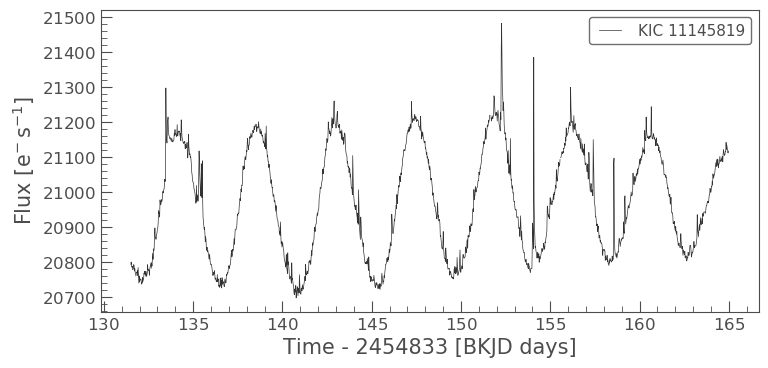

In [91]:
pdcsap_lc1.plot()

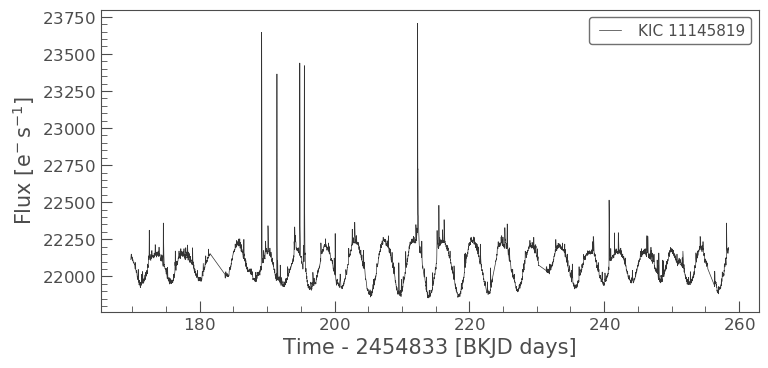

In [93]:
pdcsap_lc2.plot()

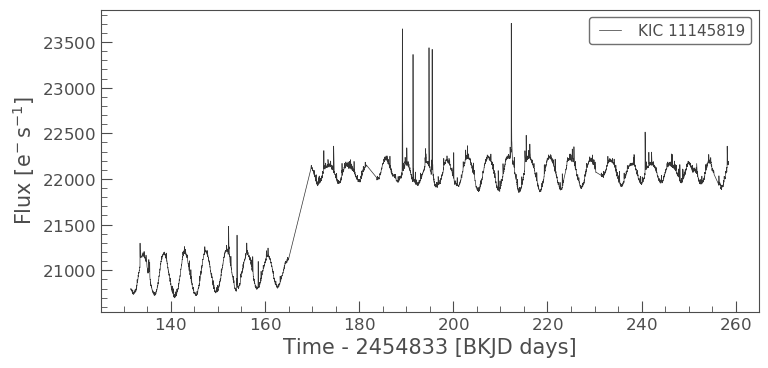

In [92]:
stitched_lc.plot()

# Lightkurve periodograms

Lightkurve has functions to create and deal with periodograms, designed to help with finding the periods of variable stars (needed for the "fold" step to remove periodic stellar variability):

In [120]:
peri_lc = search_lightcurvefile('KIC 11145819', quarter=10).download().PDCSAP_FLUX.remove_nans()
pg = peri_lc.to_periodogram(oversample_factor=1)
pg.period_at_max_power

<Quantity 4.24557945 d>

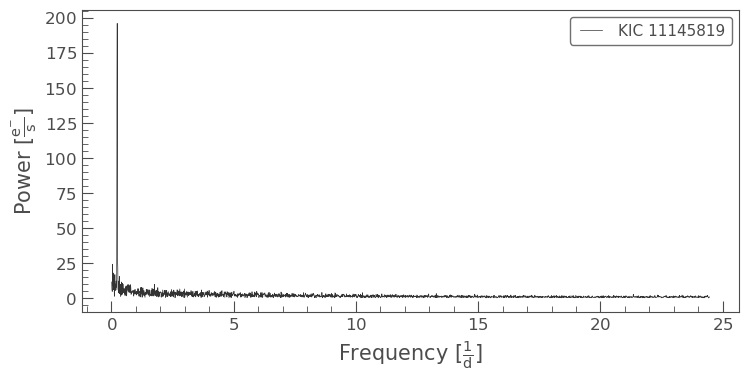

In [130]:
#periodogram plotted for reference
pg.plot();

In [131]:
#Once we have an approximate period we can make it more precise by adding a range and increasing the oversample factor:
pg_better = peri_lc.to_periodogram(minimum_period=3*u.day, maximum_period=5*u.day, oversample_factor=10)
pg_better.period_at_max_power

<Quantity 4.30813562 d>

# Combining everything in a useable way

A function I wrote to stitch all lightcurve files together in a way that can be edited/formatted using what we've covered previously (weird formatting issues require it to be done this way for it to work):

In [174]:
import lightkurve as lk
lc_list = lcf_all

#make a list of each file's quarter so the loop can start at third file even if that file's quarter isn't 3
quarters = []
for file in lc_list:
    quarters.append(file.quarter)

#edit and stitch the first two, then add to collection -
#because the collection can't be added to without already having something inside
lc_1 = search_lightcurvefile('KIC 11145819',quarter=quarters[0]).download()
lc_2 = search_lightcurvefile('KIC 11145819',quarter=quarters[1]).download()
pdcsap_lc_1 = lc_1.PDCSAP_FLUX
pdcsap_lc_2 = lc_2.PDCSAP_FLUX
pdcsap_lc_1.remove_nans()
pdcsap_lc_2.remove_nans()
lc_collection = lk.LightCurveCollection([pdcsap_lc_1,pdcsap_lc_2])

#loop starts at third file and changes them to a form that can be stitched and edited
#this can be tweaked to clip out any section of files that are interesting instead of every file
for quarter in quarters[2:]:
    lc_file = search_lightcurvefile('KIC 11145819',quarter=quarter).download()
    pdcsap_lc = lc_file.PDCSAP_FLUX
    lc_collection.append(pdcsap_lc)
    
#stitch all and edit
stitched_lc = lc_collection.stitch().remove_nans()
lc_pg = stitched_lc.to_periodogram(oversample_factor=1)
peri = lc_pg.period_at_max_power
#can plug "peri" into the period argument 
final_lc = stitched_lc.flatten().fold(period=4.295169157333749).bin(binsize=30)

In [170]:
#I use this to get a more accurate period once I have an approximate one and plug it into the period argument above
periodogram = stitched_lc.to_periodogram(minimum_period=3*u.day, maximum_period=5*u.day, oversample_factor=10)
peri_final = periodogram.period_at_max_power
print(peri_final)

4.295169157333749 d


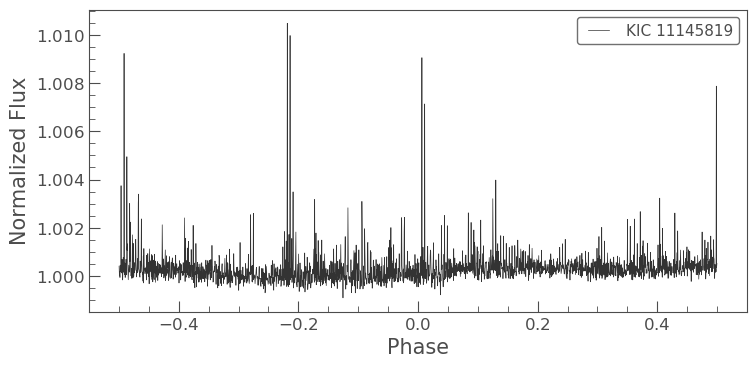

In [175]:
final_lc.plot()

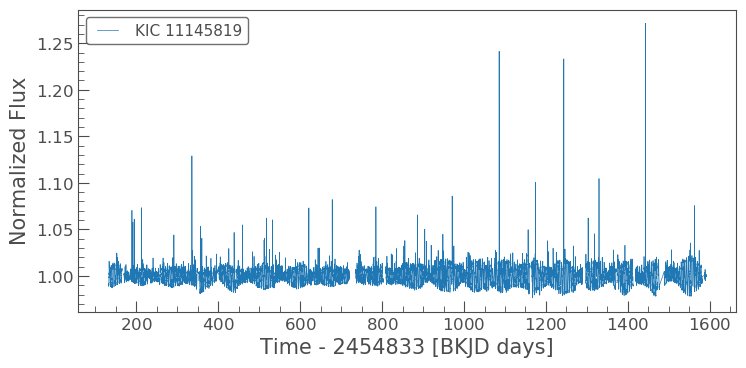

In [108]:
#unedited plot for comparison
lcf_all.PDCSAP_FLUX.plot()

# Lightkurve river plot function

Lightkurve also has a "river plot" function that is used to see how periodic signals evolve over time. This is useful for objects such as star KOI -227 which has a planet candidate that exhibits very strong transit timing variations, where the planet candidate changes its transit time, and is not exactly periodic.

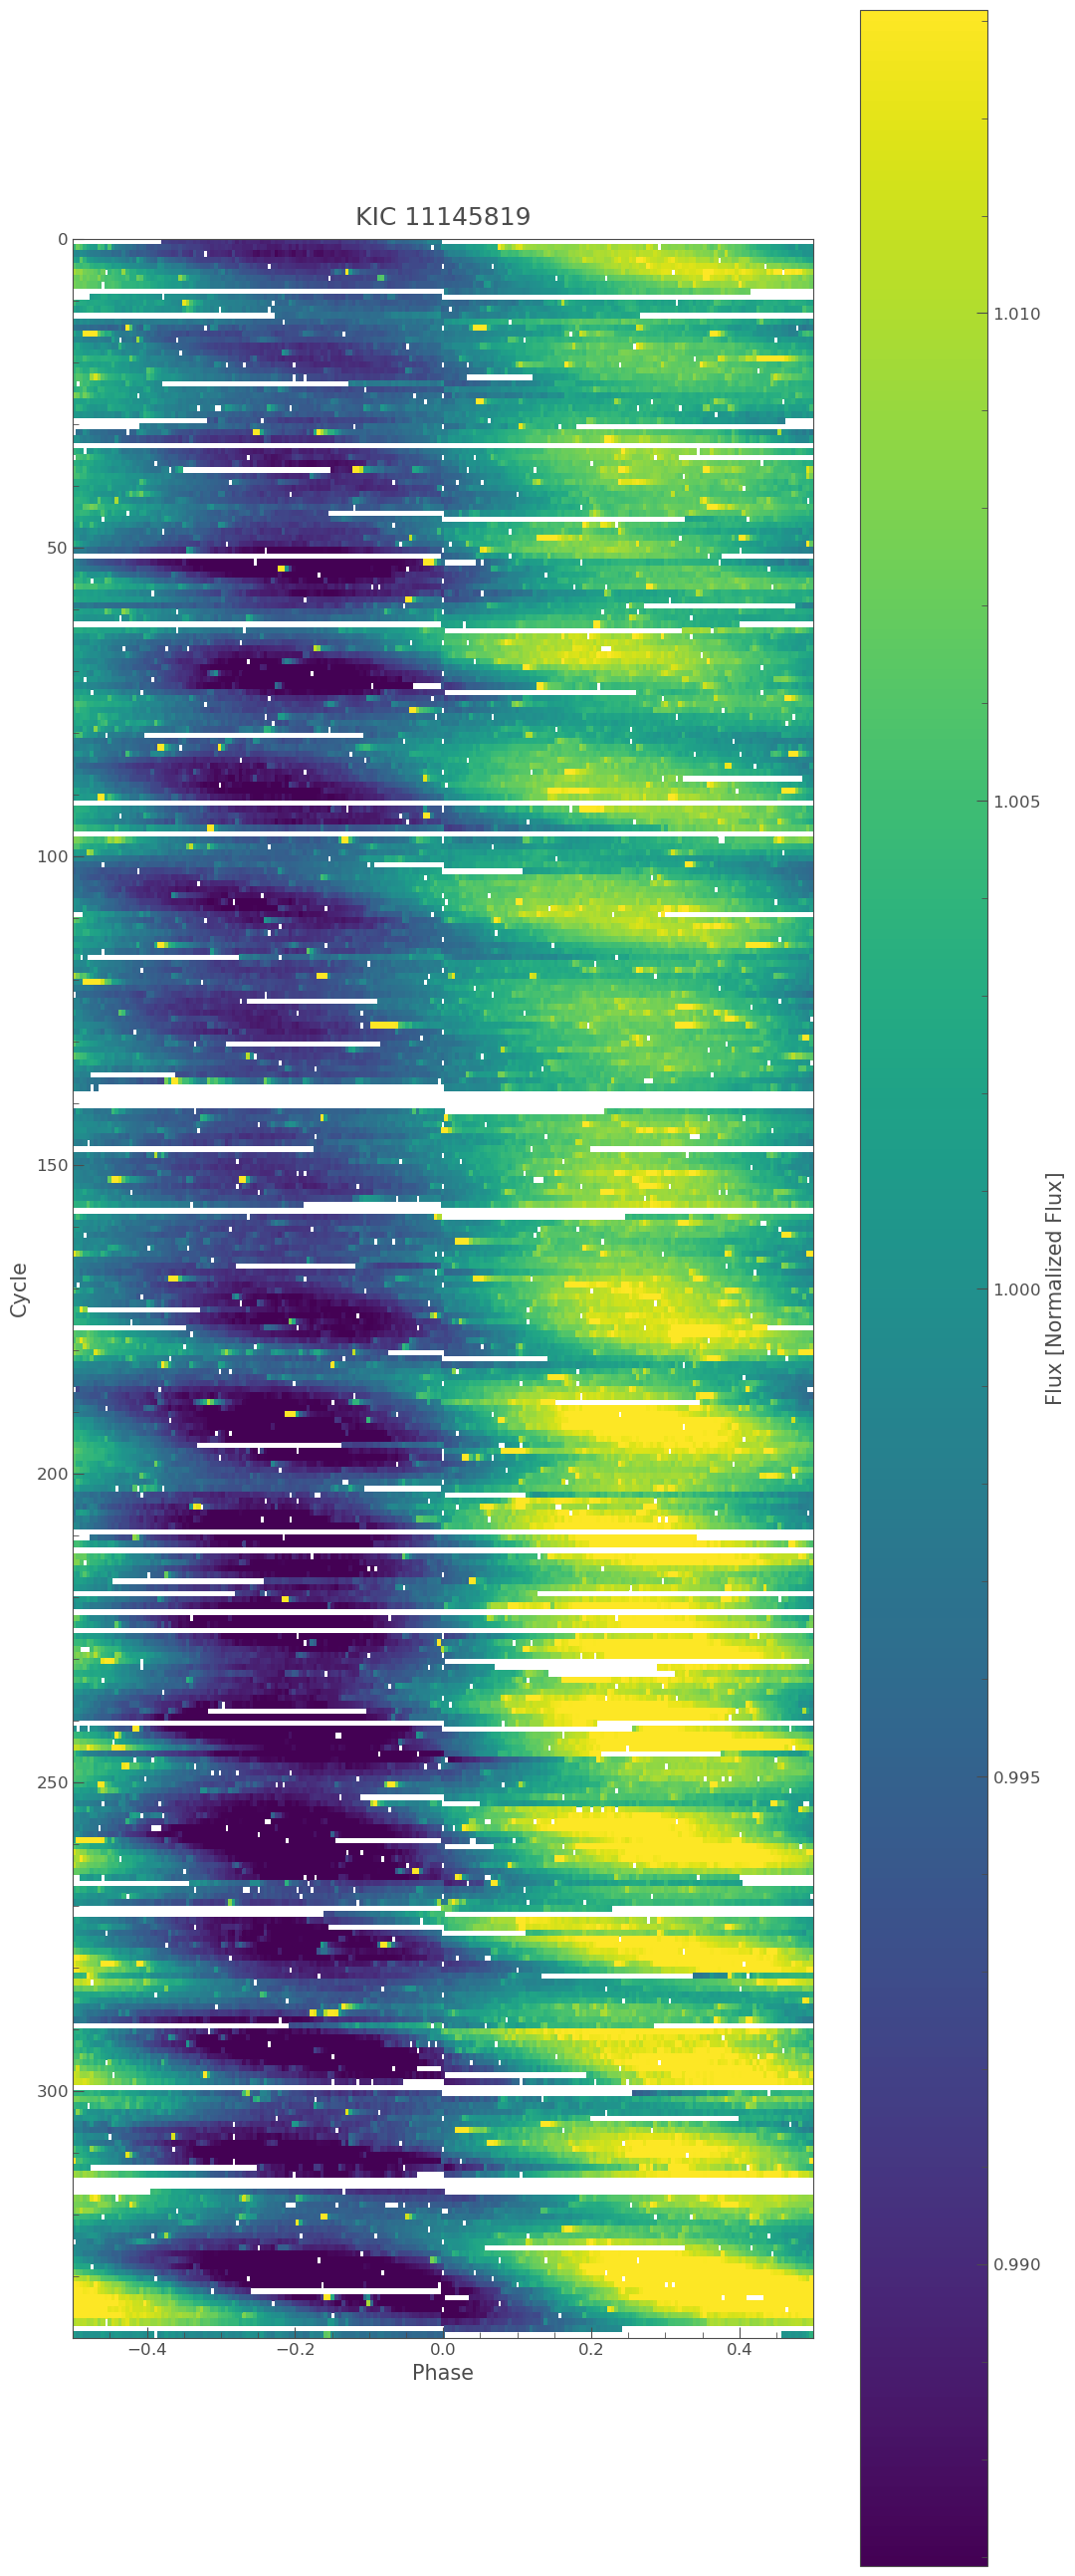

In [166]:
#The river plot for this particular star doesn't reveal anything, but the documentation website has a good visual example of KOI-227
data = lcf_all.PDCSAP_FLUX 
river_lc = data.stitch()
river_lc.flatten().fold(4.295)
river_lc.plot_river(4.295)

# TESS Data detrending/noise removal

Lightkurve has several tools for removing instrument noise and systematics from data from the Kepler, K2 and TESS missions. Here we will look at using TESS files and examine Lightkurve’s RegressionCorrector class to remove the scattered light and spacecraft motion noise from TESS Full Frame Images (FFIs). They documentation also touches on how to do this process for 2 minute cadence TESS data if needed.

In [ ]:
#This example also shows how to access a TESS object instead of a Kepler object
target = 'KIC 8462852'  # Boyajian's Star for this example
tpf = lk.search_tesscut(target, sector=15).download(cutout_size=(50, 50))
tpf
#this works the same on a Kepler target pixel file

TESS FFI cut outs do not have aperture masks created by the pipeline. Instead, users must create their own apertures. There are many methods to do this, but for now we can use a threshold aperture from Lightkurve’s create_threshold_mask() function.

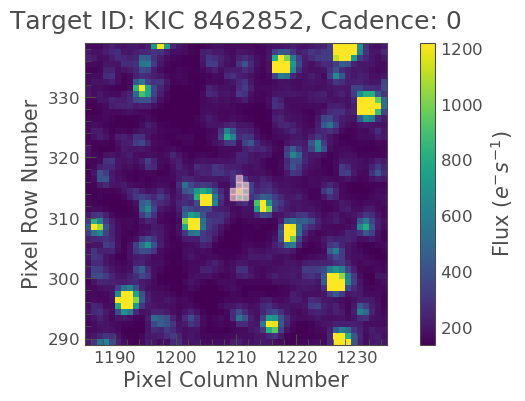

In [199]:
aper = tpf.create_threshold_mask()
#we can also plot target pixel files 
tpf.plot(aperture_mask=aper);

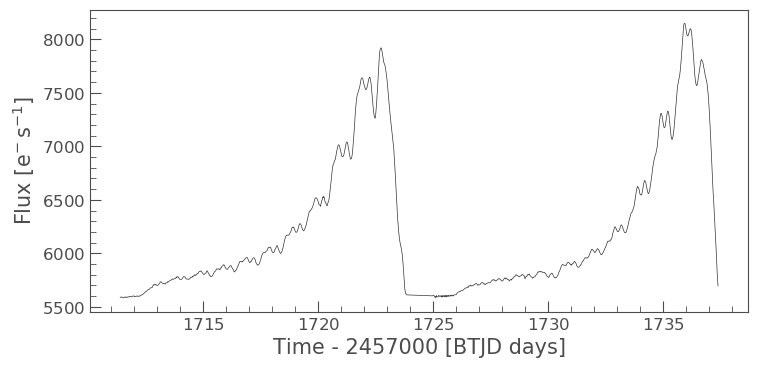

In [200]:
raw_lc = tpf.to_lightcurve(aperture_mask=aper)
raw_lc.plot();

This lightcurve seems to be dominated by scattered light (evident because TESS orbits the earth twice per sector), so we can detrend the lightcurve to remove this noise. According to the documentation, we can use the pixels outside the aperture as vectors that are highly predictive of the systematic noise, i.e. we will make the assumption that these pixels do not contain any flux from our target.

We can select these pixels very simply by specifying flux outside the aperture using Python’s bitwise invert operator ~ to take the inverse of the aperture mask.

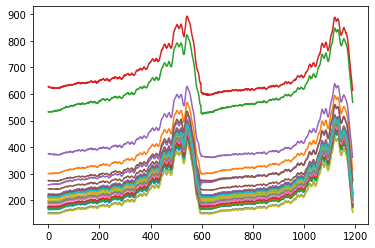

In [201]:
regressors = tpf.flux[:, ~aper]
#plots first 30 pixels
plt.plot(regressors[:, :30]);

Rather than using all of the pixels available, the documentation shows how to use principal component analysis to reduce them down to their principal components in order to accomplish a few things. According to them, by reducing to a smaller number of vectors, we can remove some of the stochastic noise in our detrending vectors and make the detrending run faster. Additionally, by reducing to the principal components, we can avoid pixels that have intrinsic variability (e.g. from astrophysical long period variables) that can be confused with the true astrophysical signal of our target. 

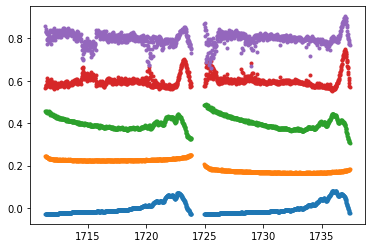

In [202]:
#This creates a design matrix with the same shape as the input pixels
dm = lk.DesignMatrix(regressors, name='regressors')
#for the amount of components, they chose 5 and mentioned you should generally choose a # less than your amount of vectors
dm = dm.pca(5)
plt.plot(tpf.time, dm.values + np.arange(5)*0.2, '.');
#these 5 principal components show a combination of scattered light and spacecraft motion

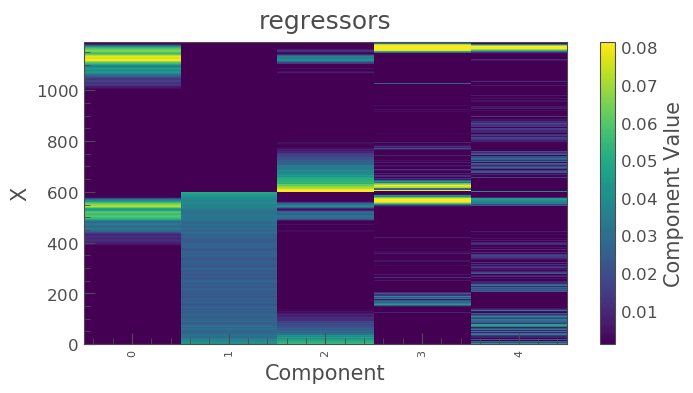

In [203]:
#this is a visual representation of the vectors
dm.plot();

We can now detrend the raw light curve against these vectors. Lightkurve’s RegressionCorrector will use linear algebra to find the combination of vectors that makes the input light curve closest to zero. To do this, we need to add an “offset” term to be able to fit the mean level of the light curve.

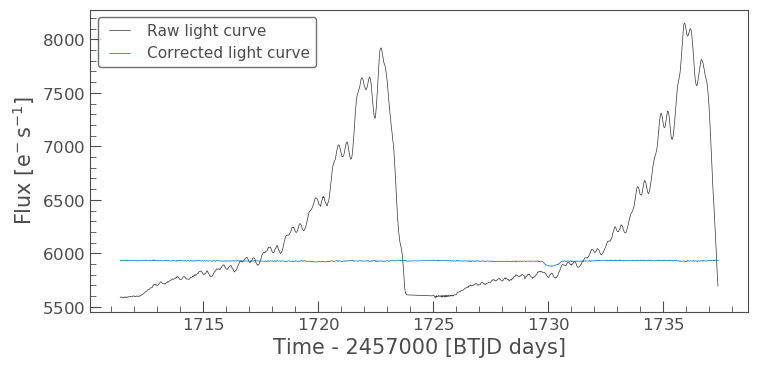

In [204]:
#Not sure if this would be removing/distorting echo and flare signals
dm = dm.append_constant()
corrector = lk.RegressionCorrector(raw_lc)
corrected_lc = corrector.correct(dm)
ax = raw_lc.plot(label='Raw light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');

As shown above, the scattered light from the background has been removed. To see a more in depth look at the correction, we can use the diagnose() method to see what the RegressionCorrector found as the best fitting solution. Regression corrector has also clipped out some outliers during the fit of the trend (which may be a problem for us). Also, the RegressionCorrector assumes that you want to remove the trend and set the lightcurve to the mean level of the raw lightkurve. This isn’t true for TESS scattered light. TESS FFI light curves have additive background, and so we want to reduce the flux to the lowest recorded level, assuming that at that point the contribution from scattered light is approximately zero. We can also look at this by using the model of the background that RegressionCorrector built. We can access that in the corrector object.

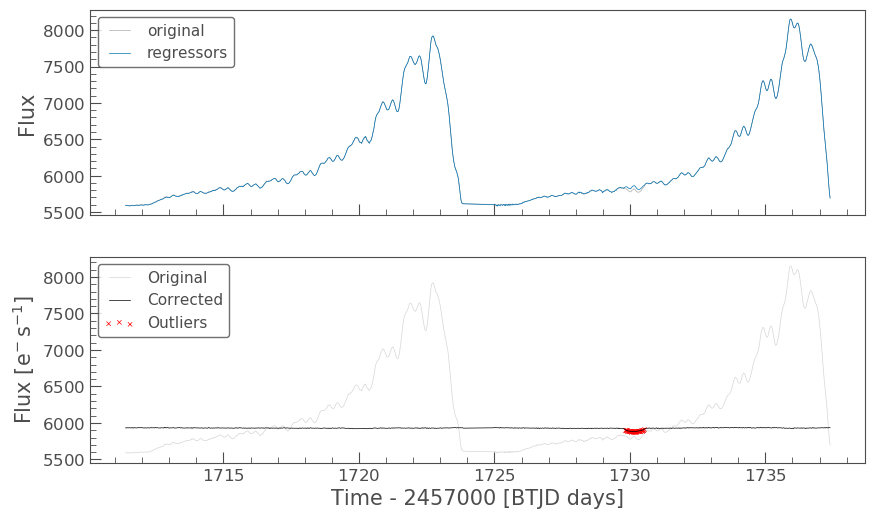

In [205]:
corrector.diagnose();

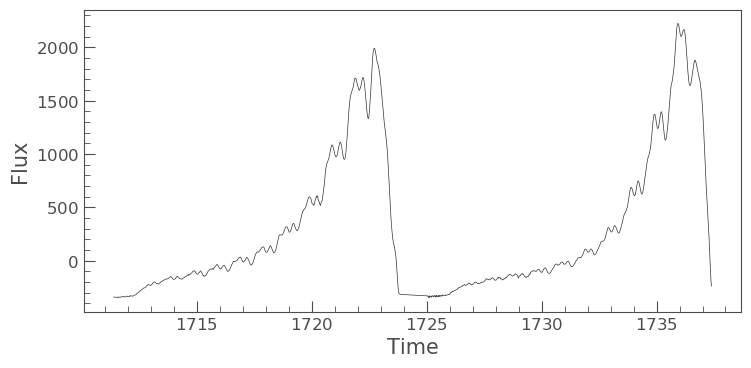

In [206]:
model = corrector.model_lc
model.plot();

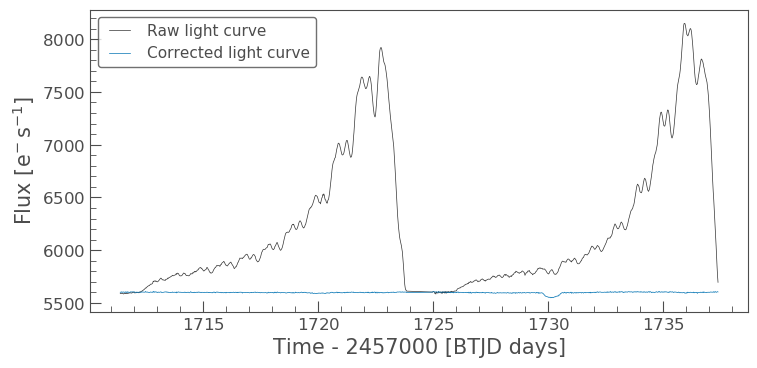

In [207]:
# Normalize to the 5th percentile of model flux
model -= np.percentile(model.flux, 5)
corrected_lc = raw_lc - model
ax = raw_lc.plot(label='Raw light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');

# Removing motion noise from K2 data using SFFCorrector:

Targets in K2 data move over multiple pixels during the exposure due to thruster firings in a typical 6 hour timescale. This can be corrected using the Self Flat Fielding method (SFF), which lightkurve has a built in fuction for. This will be demonstrated using a K2 star:

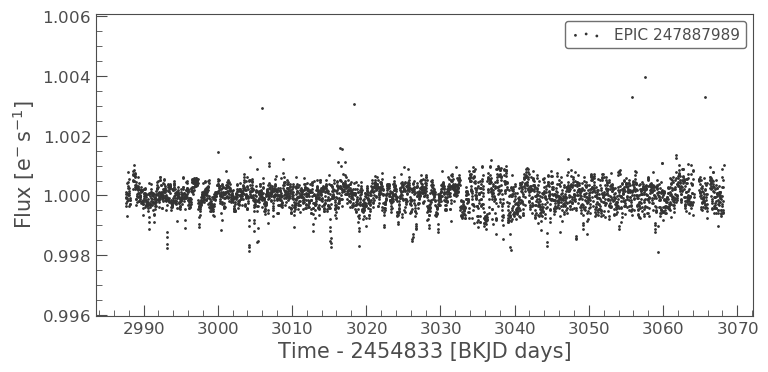

In [211]:
lcf_1 = search_lightcurvefile('EPIC 247887989').download()                   # returns a KeplerLightCurveFile
lc_1 = lcf_1.PDCSAP_FLUX.remove_nans().remove_outliers().flatten(window_length=401)             # returns a KeplerLightCurve
lc_1.scatter();

A more in depth look at how the algorithm works is available on the documentation if needed. The most basic arguments that are useful are:

degree: (int) The degree of polynomials in the splines in time and arclength.
niters: (int) Number of iterations
bins: (int) Number of bins to be used to create the piece-wise interpolation of arclength vs flux correction.
windows: (int) Number of windows to subdivide the data. The SFF algorithm is run independently in each window.

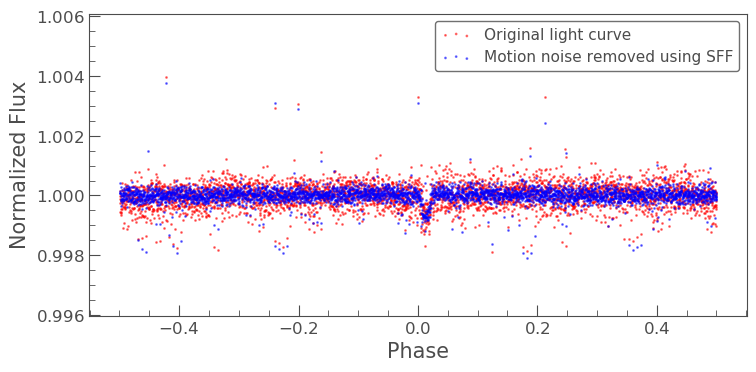

In [212]:
#for this example, they used the default values for most arguments
corr_lc = lc_1.to_corrector("sff").correct(windows=20)
#Now, a planet signal is clearly visible with the corrected data
ax = lc_1.fold(period=3.0712).scatter(color='red', alpha=0.5, label='Original light curve')
ax = corr_lc.fold(period=3.0712).scatter(ax=ax, color='blue', alpha=0.5, label='Motion noise removed using SFF');

# Removing common systematics from Kepler lightcurves using KeplerCBVCorrector

There are many different long term trends and small ramps in data due to things like heating and other effects from the spacecraft that PDC might not do a good enough job removing. However, the documentation does state that there is no guarantee only the systematics will be removed or that no noise will be introduced into the light curve when performing a sytematic error correction, so the user needs to be cautious using this.

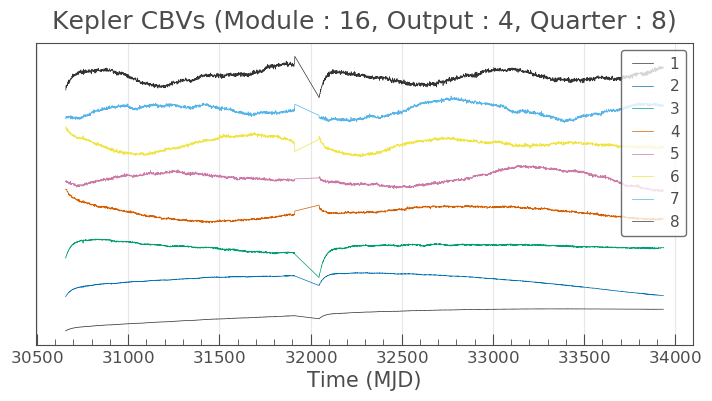

In [213]:
from lightkurve.correctors import KeplerCBVCorrector
#This example uses Tabby's star
tabby_lcf = search_lightcurvefile('KIC 8462852', quarter=8).download()
#Shows us the top 8 trends present in the data that it will remove
KeplerCBVCorrector(tabby_lcf).plot_cbvs([1,2,3,4,5,6,7,8]);

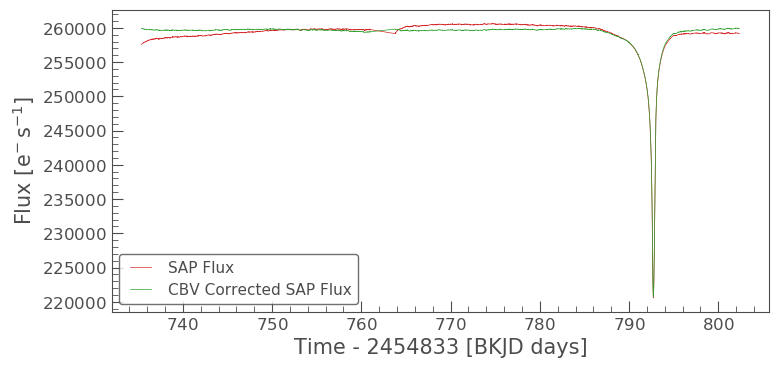

In [216]:
#In order to not over fit, we just remove the first 5 (higher index value=higher noise)
corr_lc =  KeplerCBVCorrector(tabby_lcf).correct(cbvs=[1,2,3,4,5])
lc_SAP = tabby_lcf.SAP_FLUX
ax = lc_SAP.plot(color='C3', label='SAP Flux', linestyle='-')
corr_lc.plot(ax=ax, color='C2', label='CBV Corrected SAP Flux', linestyle='-');

The documentation also runs through examples on how to recover a known planet in Kepler data, how to recover the first TESS planet candidate, how to use machine learning preprocessing with lightkurve, how to improve signal to noise of periodograms, and how to characterize stars using astroseismology. 